#### CPS matching observations one year apart

April 11, 2019

----

To Do:

Refactor and clean up code. Add comments. Parameterize!

Refactoring:

* Read cps feather file only once per year.

* Filter dataframe columns when reading.

In [1]:
# Import packages and set preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

os.chdir('/home/brian/Documents/CPS/')

In [2]:
cols = ['MONTH', 'YEAR', 'WBHAO',
        'CPSID', 'AGE', 'FEMALE', 'PTECON',
        'LFS', 'MIS', 'BASICWGT', 'LINENO']

emp = lambda x: np.where((x.LFS == 'Employed') & 
                         (x.PTECON == 0), 1, 0)

grp = lambda x: np.where((x.FEMALE == 1) & (x.AGE >= 25) & (x.AGE <= 54), 'Women, 25-54', 
                np.where((x.FEMALE == 0) & (x.AGE >= 25) & (x.AGE <= 54), 'Men, 25-54', 0))

In [3]:
result = pd.DataFrame()
for year in range(1997, 2022):
    df1 = (pd.read_feather(f'data/clean/cps{year-1}.ft', columns=cols)
             .assign(EMP = emp, GRP = grp)
             .query('EMP == 1'))

    df2 = (pd.read_feather(f'data/clean/cps{year}.ft', columns=cols)
             .assign(EMP = emp, GRP = grp)
             .query('GRP != 0'))

    data = pd.merge(df1, df2, on=['MONTH', 'CPSID', 'LINENO', 'FEMALE', 'WBHAO'])
    result = result.append(1 - data.groupby(['YEAR_y', 'MONTH', 'GRP_y'])
                                   .apply(lambda x: np.average(x.EMP_y, weights=x.BASICWGT_y))
                                   .unstack().drop('0', axis=1))
    
dates = pd.to_datetime({'year': [year for year, month in result.index], 
                        'month': [month for year, month in result.index], 
                        'day': [1 for year, month in result.index]})
result.index = dates

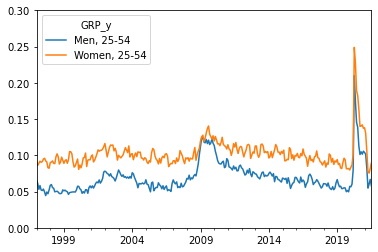

In [4]:
result.plot()
plt.ylim(0, 0.3)
plt.show()